In this notebook, we can test the performance of a previously trained GrappaNet model on test images

In [1]:
import os
import h5py
import random
from pygrappa import grappa
import matplotlib.pyplot as plt
from numpy import fft 
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input,BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.layers import PReLU, add, Attention, Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

crop_size = (12,640,320)


model = None
kernel_size = (3,3)
loss_weights = [1.0, 0.0001, 0.000001]

selected_layers = ['block1_conv1', 'block2_conv2', 'block3_conv3' ,'block4_conv3']
selected_layer_weights_content = [0.001, 0.01, 2, 4]

vgg = VGG19(weights='imagenet', include_top=False, input_shape=(crop_size[1],crop_size[2],3))
vgg.trainable = False

outputs = [vgg.get_layer(l).output for l in selected_layers]
vgg_model = Model(vgg.input, outputs)
vgg_model.trainable = False

def model_loss_all(y_true, y_pred):
    global vgg_model
    global loss_weights
    global selected_layer_weights_content
    
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(img1=y_true,img2=y_pred,max_val=1.0,filter_size=3,filter_sigma=0.1))
    pixel_loss = tf.reduce_mean(tf.math.abs(y_true-y_pred))
    
    content_loss = 0.0
    res_y_rss = tf.image.grayscale_to_rgb(y_true*255)
    res_y_rss = preprocess_input(res_y_rss)
    vgg_f_gt = vgg_model(res_y_rss)

    res_y_pred = tf.image.grayscale_to_rgb(y_pred*255)
    res_y_pred = preprocess_input(res_y_pred)
    vgg_f_pred = vgg_model( res_y_pred)

    for h1, h2, cw in zip(vgg_f_gt, vgg_f_pred, selected_layer_weights_content):
        content_loss = content_loss + cw *tf.reduce_mean(tf.square(tf.math.abs(h1 - h2)))
    
    return loss_weights[0]*ssim_loss+loss_weights[1]*pixel_loss +loss_weights[2]*content_loss

def conv_block(ip, nfilters, drop_rate):
    
    layer_top = Conv2D(nfilters, (3,3), padding = "same")(ip)
    layer_top = BatchNormalization()(layer_top)

    res_model = PReLU()(layer_top)
    res_model = Dropout(drop_rate)(res_model)
    
    res_model = Conv2D(nfilters, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization()(res_model)

    res_model = Dropout(drop_rate)(res_model)
    res_model = add([layer_top,res_model])
    res_model = PReLU()(res_model)
    return res_model

def encoder(inp, nlayers, nbasefilters, drop_rate):
    
    skip_layers = []
    layers = inp
    for i in range(nlayers):
        layers = conv_block(layers,nbasefilters*2**i,drop_rate)
        
        #attention
        #layers = Attention()([layers,layers])
        
        skip_layers.append(layers)
        layers = MaxPooling2D((2,2))(layers)
    
    return layers, skip_layers

def decoder(inp, nlayers, nbasefilters,skip_layers, drop_rate):
    
    layers = inp
    for i in range(nlayers):
        layers = conv_block(layers,nbasefilters*(2**(nlayers-1-i)),drop_rate)
        
        #attention
        #layers=Attention()([layers,layers])
        #mul_layer = MultiHeadAttention(num_heads=2, key_dim=2, attention_axes=(1,2, 3))
        #layers=mul_layer(layers, layers)
        
        #layers=UpSampling2D((2,2))(layers)
        layers=Conv2DTranspose(kernel_size=(2,2),filters=nbasefilters*(2**(nlayers-1-i)),strides=(2,2), padding='same')(layers)
        layers=add([layers,skip_layers.pop()])
    return layers

def create_gen(gen_ip, nlayers, nbasefilters, drop_rate):
    op,skip_layers = encoder(gen_ip,nlayers, nbasefilters,drop_rate)
    op = decoder(op,nlayers, nbasefilters,skip_layers,drop_rate)
    op = Conv2D(1, (3,3), padding = "same")(op)
    return Model(inputs=gen_ip,outputs=op)

input_shape = (crop_size[1],crop_size[2],crop_size[0])
input_layer = Input(shape=input_shape)
model = create_gen(input_layer,5,32,0.01)



In [1]:
import os
import h5py
import random
from pygrappa import grappa
import matplotlib.pyplot as plt
from numpy import fft 
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Input,BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.layers import PReLU, add, Attention, Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input

crop_size = (12,640,320)


model = None
kernel_size = (3,3)
loss_weights = [1.0, 0.0001, 0.000001]

selected_layers = ['block1_conv1', 'block2_conv2', 'block3_conv3' ,'block4_conv3']
selected_layer_weights_content = [0.001, 0.01, 2, 4]

vgg = VGG19(weights='imagenet', include_top=False, input_shape=(crop_size[1],crop_size[2],3))
vgg.trainable = False

outputs = [vgg.get_layer(l).output for l in selected_layers]
vgg_model = Model(vgg.input, outputs)
vgg_model.trainable = False

def model_loss_all(y_true, y_pred):
    global vgg_model
    global loss_weights
    global selected_layer_weights_content
    
    # Remove abs() from the ssim loss
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(img1=y_true,img2=y_pred,max_val=1.0,filter_size=3,filter_sigma=0.1))
    pixel_loss = tf.reduce_mean(tf.math.abs(y_true-y_pred))
    
    content_loss = 0.0
    res_y_rss = tf.image.grayscale_to_rgb(y_true*255)
    res_y_rss = preprocess_input(res_y_rss)
    vgg_f_gt = vgg_model(res_y_rss)

    res_y_pred = tf.image.grayscale_to_rgb(y_pred*255)
    res_y_pred = preprocess_input(res_y_pred)
    vgg_f_pred = vgg_model( res_y_pred)

    for h1, h2, cw in zip(vgg_f_gt, vgg_f_pred, selected_layer_weights_content):
        content_loss = content_loss + cw *tf.reduce_mean(tf.square(tf.math.abs(h1 - h2)))
    
    return loss_weights[0]*ssim_loss+loss_weights[1]*pixel_loss +loss_weights[2]*content_loss

def conv_block(ip, nfilters, drop_rate):
    
    layer_top = Conv2D(nfilters, (3,3), padding = "same")(ip)
    layer_top = BatchNormalization()(layer_top)

    res_model = PReLU()(layer_top)
    res_model = Dropout(drop_rate)(res_model)
    
    res_model = Conv2D(nfilters, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization()(res_model)

    res_model = Dropout(drop_rate)(res_model)
    res_model = add([layer_top,res_model])
    res_model = PReLU()(res_model)
    return res_model

def encoder(inp, nlayers, nbasefilters, drop_rate):
    
    skip_layers = []
    layers = inp
    for i in range(nlayers):
        layers = conv_block(layers,nbasefilters*2**i,drop_rate)
        
        # Attention layer
        #layers = Attention()([layers,layers])
        
        skip_layers.append(layers)
        layers = MaxPooling2D((2,2))(layers)
    return layers, skip_layers

def decoder(inp, nlayers, nbasefilters,skip_layers, drop_rate):
    
    layers = inp
    for i in range(nlayers):
        layers = conv_block(layers,nbasefilters*(2**(nlayers-1-i)),drop_rate)
        
        # Attention layer
        #layers=Attention()([layers,layers])
        #mul_layer = MultiHeadAttention(num_heads=2, key_dim=2, attention_axes=(1,2, 3))
        #layers=mul_layer(layers, layers)
        
        #layers=UpSampling2D((2,2))(layers)
        layers=Conv2DTranspose(kernel_size=(2,2),filters=nbasefilters*(2**(nlayers-1-i)),strides=(2,2), padding='same')(layers)
        layers=add([layers,skip_layers.pop()])
    return layers

def create_gen(gen_ip, nlayers, nbasefilters, drop_rate):
    op,skip_layers = encoder(gen_ip,nlayers, nbasefilters,drop_rate)
    op = decoder(op,nlayers, nbasefilters,skip_layers,drop_rate)
    op = Conv2D(1, (3,3), padding = "same")(op)
    # Add sigmoid activation layer to force output images to have pixel values [0,1]
    op = Activation('sigmoid')(op)
    return Model(inputs=gen_ip,outputs=op)

input_shape = (crop_size[1],crop_size[2],crop_size[0])
input_layer = Input(shape=input_shape)
model = create_gen(input_layer,5,32,0.01)



In [2]:
#model.load_weights('/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/Models/best_model_DeepMRIRec.h5')
#model.load_weights('/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/Models/final_model_DeepMRIRec.h5')
model.load_weights('/usr/local/micapollo01/MIC/DATA/STUDENTS/mvhave7/Results/Models/best_model_DeepMRIRec_trained_in_batches.h5')


In [3]:
# pre-trained model available online

#with open('/home/mvhave7/GitLab/master_thesis/DeepMRIRec/pre_trained/model_unetcbi_X.json', 'r') as f:
#    json_string = f.read()
#model = tf.keras.models.model_from_json(json_string)


In [3]:
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 640, 320, 12 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 640, 320, 32) 3488        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 640, 320, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
p_re_lu (PReLU)                 (None, 640, 320, 32) 6553600     batch_normalization[0][0]        
____________________________________________________________________________________________

In [4]:
# Load test data

download_path = '/usr/local/micapollo01/MIC/DATA/SHARED/NYU_FastMRI'
test_path = os.path.join(download_path,'multicoil_test')
test_target_path = os.path.join(download_path,'multicoil_test_full')

#file_name = 'file_brain_AXFLAIR_201_6002891.h5'
file_name = 'file_brain_AXT2_205_6000143.h5'


In [5]:
def calculate_mask(mask,start,end,nPE):
    '''
    The mask contains more information from the center of k-space. 
    We divide phase encoding space into nine areas/slots (see Figure 3 from paper, nine slots are separated by red dotted lines) 
    and select 10% of data points from the center area and 4%, 2%,1%, and 0.5% from the area adjacent to the centers
    In total, we thus retain 10% + (4+2+1+0.5)*2 % = 25% of the original k-space. This way, we obtain R=4.
    '''
    
    total_point = start
    max_len = nPE
    number_of_sample = (max_len/4)-(end-start)
    step = int((4*start)/number_of_sample)
    i = step
    f = 1
    indx = 1
    while i < total_point+1:
        offset = 10 + int(random.sample(range(0,3), 1)[0])
        if offset+i < total_point:
            mask[:,:,:,offset+i] = 1
        else:
            mask[:,:,:,i] = 1

        offset = 5 + int(random.sample(range(0,3), 1)[0])
        if i-offset > 0:
            mask[:,:,:,max_len-i-offset] = 1
        else:
            mask[:,:,:,max_len-i] = 1
        i = i+step
        indx = indx+1
        if i >= ((total_point*f)//2):
            step = int(step/3)
            f = f+1
    return mask

def Grappa_recon(kspace,start, end):
    calib = kspace[:,:,start:end].copy()
    res = grappa(kspace, calib, kernel_size=(5,5),coil_axis=0)
    return res

def comp_img(img,crop_size):
    s = img.shape
    start_height = s[1]//2 - (crop_size[1]//2)
    start_width = s[2]//2 - (crop_size[2]//2)
    return img[:,start_height:(start_height+crop_size[1]),start_width:(start_width+crop_size[2])]


In [6]:
# Now, we start the test data construction and GRAPPA image reconstruction estimation

last_mask = None
X_test = []
Y_test = []

with h5py.File(os.path.join(test_target_path, file_name),'r') as f:

    k = f['kspace'][()]
    sequence = f.attrs['acquisition']
    nSL, nCh, nFE, nPE = k.shape
     
    # Select ACS region
    mid = nPE//2
    start = mid-int(nPE*0.05)
    end = mid+int(nPE*0.05)
       
    mask = 0*k
    mask[:,:,:,start:end] = 1
    mask = calculate_mask(mask,start,end,nPE)  
    last_mask = mask
    subsampled_k = k*mask
    ts = time.time()
    if nCh > 18:
        channels_picked = [0,1,2,4,7,8,11,13,15,16,17,18]
    elif nCh > 12 and nCh < 18:
        channels_picked = [0,1,2,3,4,5,6,7,8,10,11,12]
    else:
        channels_picked = []
    if len(channels_picked)>0:
        for slices in range(nSL): 
            chindx = 0
            ref_img = np.zeros((len(channels_picked),nFE,nPE),dtype=np.float32)
            sub_img = np.zeros((len(channels_picked),nFE,nPE),dtype=np.float32)
            subsampled_tmp = Grappa_recon(subsampled_k[slices,:,:,:],start,end)    
            for iCh in channels_picked:
                sub_img[chindx,:,:] = abs(fft.fftshift(fft.ifft2(subsampled_tmp[iCh,:,:])))
                ref_img[chindx,:,:] = abs(fft.fftshift(fft.ifft2(k[slices,iCh,:,:])))
                chindx = chindx+1
            X_test.append(list(comp_img(sub_img,crop_size)))
            Y_test.append(list(comp_img(ref_img,crop_size)))
        print(sequence,nSL,nCh,nFE,nPE,sub_img.shape,"ACS region indices: ",start,end,"Processing time: ", time.time()-ts)
X_test_arr = np.array(X_test).astype(np.float32)
Y_test_arr = np.array(Y_test).astype(np.float32)
print("X_test and Y_test constructed with shapes: ",X_test_arr.shape,Y_test_arr.shape)

X_test_arr = np.transpose(X_test_arr,(0,2,3,1))
Y_test_arr = np.transpose(Y_test_arr,(0,2,3,1))


Y_rss = np.sqrt(np.sum(np.square(Y_test_arr),axis=3))
Y_rss = Y_rss.astype(np.float32)


dims = X_test_arr.shape

for i in range(dims[0]):
    for j in range(dims[3]):
        X_test_arr[i,:,:,j] = X_test_arr[i,:,:,j]/((np.max(X_test_arr[i,:,:,j])-np.min(X_test_arr[i,:,:,j]))+1e-10)

for i in range(dims[0]):
    Y_rss[i,:,:] = Y_rss[i,:,:]/((np.max(Y_rss[i,:,:])-np.min(Y_rss[i,:,:]))+1e-10)


AXT2 16 16 640 320 (12, 640, 320) ACS region indices:  144 176 Processing time:  108.80855441093445
X_test and Y_test constructed with shapes:  (16, 12, 640, 320) (16, 12, 640, 320)


In [7]:
# Select a slice to predict
slice = 3
coil = 0

test_slice_kspace = subsampled_k[slice,coil,:,:]
test_slice_image = X_test_arr[slice,:,:,coil]
test_target_slice_image = Y_rss[slice,:,:]

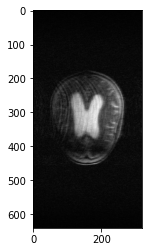

In [9]:
# Reconstruction for just this single-coil subsampled k-space test slice
plt.imshow(abs(fft.fftshift(fft.ifft2(test_slice_kspace))), cmap = 'gray')


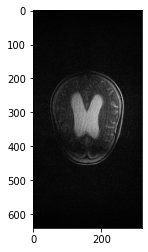

In [10]:
# Reconstruction for just this single-coil Grappa-processed k-space test slice (this is the input of the model)
plt.imshow(test_slice_image, cmap = 'gray')


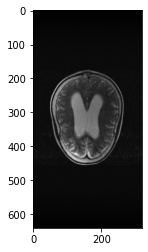

In [11]:
plt.imshow(test_target_slice_image,cmap='gray')


In [8]:
# Make prediction with our model

reconstructed_test_image = model.predict(X_test_arr)
#reconstructed_test_image = np.squeeze(reconstructed_test_image)
reconstructed_test_image = reconstructed_test_image[:,:,:,0]


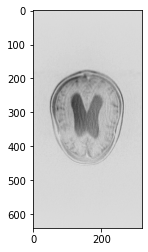

In [13]:
# Best model, small training dataset
plt.imshow(reconstructed_test_image[slice,:,:], cmap='gray')


In [12]:
def mse(actual, pred): 
   actual, pred = np.array(actual), np.array(pred)
   return np.square(np.subtract(actual,pred)).mean()

def nmse(actual, pred):
   mse_result = mse(actual, pred)
   return mse_result/(np.square(actual).mean())

nmse_reconstruction = nmse(test_target_slice_image,reconstructed_test_image[slice,:,:])
print(nmse_reconstruction)


3.0060248


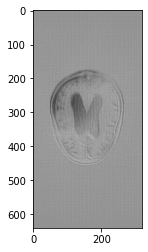

In [19]:
# Final model, small training dataset
plt.imshow(reconstructed_test_image[slice,:,:], cmap='gray')


In [18]:
def mse(actual, pred): 
   actual, pred = np.array(actual), np.array(pred)
   return np.square(np.subtract(actual,pred)).mean()

def nmse(actual, pred):
   mse_result = mse(actual, pred)
   return mse_result/(np.square(actual).mean())

nmse_reconstruction = nmse(test_target_slice_image,reconstructed_test_image[slice,:,:])
print(nmse_reconstruction)


2.2566152


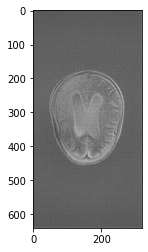

In [12]:
# Trained model after 1 epoch of training on 90 batches of data
plt.imshow(reconstructed_test_image[slice,:,:], cmap='gray')


In [13]:
def mse(actual, pred): 
   actual, pred = np.array(actual), np.array(pred)
   return np.square(np.subtract(actual,pred)).mean()

def nmse(actual, pred):
   mse_result = mse(actual, pred)
   return mse_result/(np.square(actual).mean())

nmse_reconstruction = nmse(test_target_slice_image,reconstructed_test_image[slice,:,:])
print(nmse_reconstruction)


0.48254952


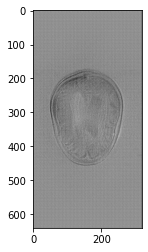

In [13]:
# Trained model after 3 epochs of training on 90 batches of data
plt.imshow(reconstructed_test_image[slice,:,:], cmap='gray')


In [14]:
def mse(actual, pred): 
   actual, pred = np.array(actual), np.array(pred)
   return np.square(np.subtract(actual,pred)).mean()

def nmse(actual, pred):
   mse_result = mse(actual, pred)
   return mse_result/(np.square(actual).mean())

nmse_reconstruction = nmse(test_target_slice_image,reconstructed_test_image[slice,:,:])
print(nmse_reconstruction)


1.2569479


In [15]:
# Test clipping function
reconstructed_test_image_clipped = np.clip(reconstructed_test_image[slice,:,:], 0, 1)


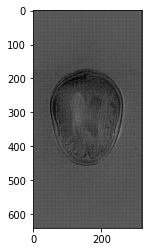

In [17]:
plt.imshow(reconstructed_test_image_clipped, cmap='gray')


In [18]:
# Test pixel-value shifting function
def pixel_shift(image):
    min_val = np.array(image).min()
    shifted_image = np.array(image) + min_val
    return shifted_image 

reconstructed_test_image_shifted = pixel_shift(reconstructed_test_image[slice,:,:])

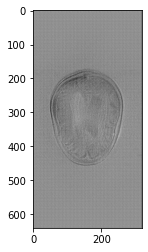

In [19]:
plt.imshow(reconstructed_test_image_shifted, cmap='gray')


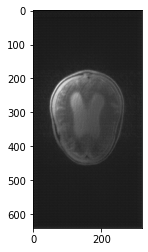

In [10]:
# Trained model with sigmoid layer after 1 epoch of training on 90 batches of data
plt.imshow(reconstructed_test_image[slice,:,:], cmap='gray')


In [11]:
def mse(actual, pred): 
   actual, pred = np.array(actual), np.array(pred)
   return np.square(np.subtract(actual,pred)).mean()

def nmse(actual, pred):
   mse_result = mse(actual, pred)
   return mse_result/(np.square(actual).mean())

nmse_reconstruction = nmse(test_target_slice_image,reconstructed_test_image[slice,:,:])
print(nmse_reconstruction)


1.0514082


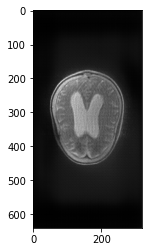

In [9]:
# Trained model with sigmoid layer after 3 epochs of training on 90 batches of data
plt.imshow(reconstructed_test_image[slice,:,:], cmap='gray')


In [10]:
def mse(actual, pred): 
   actual, pred = np.array(actual), np.array(pred)
   return np.square(np.subtract(actual,pred)).mean()

def nmse(actual, pred):
   mse_result = mse(actual, pred)
   return mse_result/(np.square(actual).mean())

nmse_reconstruction = nmse(test_target_slice_image,reconstructed_test_image[slice,:,:])
print(nmse_reconstruction)


0.1254116


In [30]:
# Make prediction with the pre-trained model (which works with cropped images of size )

def comp_img(img,crop_size):
    s = img.shape
    start_height = s[0]//2 - (crop_size[1]//2)
    start_width = s[1]//2 - (crop_size[2]//2)
    return img[start_height:(start_height+crop_size[1]),start_width:(start_width+crop_size[2]),:]

X_test_arr_cropped = []
for slices in range(nSL):
    X_test_arr_cropped.append(list(comp_img(X_test_arr[slices,:,:,:],(12,256,192))))

X_test_arr_cropped = np.array(X_test_arr_cropped).astype(np.float32)

reconstructed_test_image = model.predict(X_test_arr_cropped)
#reconstructed_test_image = np.squeeze(reconstructed_test_image)
reconstructed_test_image = reconstructed_test_image[:,:,:,0]


In [31]:
X_test_arr_cropped.shape

(16, 256, 192, 12)

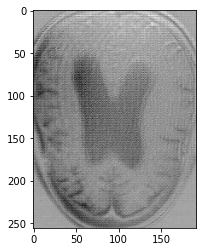

In [33]:
# Pre-trained model
plt.imshow(reconstructed_test_image[slice,:,:], cmap='gray')


In [32]:
def mse(actual, pred): 
   actual, pred = np.array(actual), np.array(pred)
   return np.square(np.subtract(actual,pred)).mean()

def nmse(actual, pred):
   mse_result = mse(actual, pred)
   return mse_result/(np.square(actual).mean())

nmse_reconstruction = nmse(np.sqrt(np.sum(np.square(X_test_arr_cropped[slice,:,:,:]),axis=2)).astype(np.float32),reconstructed_test_image[slice,:,:])
print(nmse_reconstruction)


1.3928292
